### Summary
The code present in this notebook provides a tutorial on using Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize and interpret the activations of a CNN (Convolutional Neural Network) model. The tutorial demonstrates how to use Grad-CAM for object localization and fine-tuning the model to improve its accuracy.

The tutorial uses `PyTorch`, a popular deep learning framework, and provides step-by-step instructions on implementing Grad-CAM on a pre-trained CNN model. It also includes code for computing CAM (Class Activation Mapping) metrics, which can be used to evaluate the quality of the Grad-CAM visualizations.

Additionally, the tutorial provides guidance on tuning hyperparameters such as learning rate, weight decay, and momentum to improve model performance. It also includes code for visualizing the feature maps and gradients of the CNN model, which can aid in understanding how the model is making predictions. Overall, the tutorial is a comprehensive guide to using Grad-CAM for model interpretation and improvement.

<hr>
<hr>

One of the main focuses of the tutorial is on exploring the different metrics that can be used to compare and evaluate pixel attribution techniques.

The tutorial explains the importance of measuring the quality of model explanations and provides insight into the kind of problems that arise when using metrics for model explanations. Moreover, the tutorial demonstrates how we can use these metrics to fine-tune the model explanations and improve the model's overall performance.

 

1.   The tutorial uses the pytorch-grad-cam package and provides a step-by-step guide to extracting the different metrics available in the package.
2.  Includes examples of how to use these metrics to improve model explanations for images.

Overall, this tutorial serves as a valuable resource for anyone looking to benchmark and tune model explanations. By understanding the different metrics and their practical applications, readers can gain insights into the inner workings of their models and improve their performance.




In [2]:
%cd /content/drive/MyDrive/Notebook

/content/drive/MyDrive/Notebook


This command installs the following packages:

*   `numpy`: a library for numerical computing in Python.
*   `Pillow`: a library for opening, manipulating, and saving images in Python.
*   `torch` and `torchvision`: libraries for deep learning in PyTorch.
*   `ttach`: a library for test time augmentation in PyTorch.
*   `tqdm`: a library for displaying progress bars in Python.
*   `opencv-python`: a library for computer vision in Python.
*   `matplotlib`: a library for creating visualizations in Python.
*   `scikit-learn`: a library for machine learning in Python.

The `!` at the beginning of the command is used to run a shell command in the Colab notebook. This command installs the required packages in the current environment and makes them available for use in the notebook.

In [3]:
#!pip install numpy Pillow torch>=1.7.1 torchvision>=0.8.2 tqdm opencv-python matplotlib scikit-learn
!pip install ttach

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import sys
sys.path.extend(['/content/drive/MyDrive/Notebook', '/content/drive/MyDrive/Notebook/Toolkit/utils', '/content/drive/MyDrive/Notebook/library'])

In the GradCAM++ paper image above the masked images are black, so it looks like they are multiplying the original image, before the image-net normalization.

I'm pretty sure that most of the methods that came after that, multiplied the tensor in the input to the model, after image-net normalization.

Both should be similar, but with difference that maybe black pixels (multiplying pre normalization) make the images look more different than the distribution of natural images, and maybe that has some effect.

No one is sharing the CAM evaluation code, and no one is commenting about that implementation detail in the papers, so I'm pretty sure the different papers are using differnt metrics ;-)

Before moving on to other metrics, lets take a first look at how to use these metrics in the pytorch-grad-cam package.

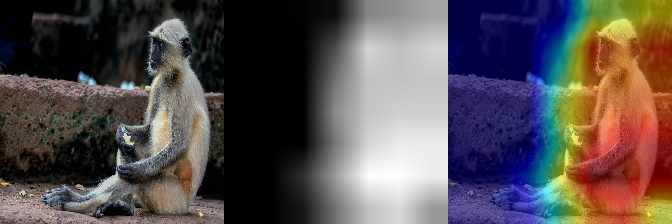

In [7]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests

from grad_cam import GradCAM
from model_targets import ClassifierOutputTarget
from image import show_cam_on_image, deprocess_image, preprocess_image
from PIL import Image

model = models.resnet50(pretrained=True)
model.eval()

# Fetch an image from an URL
#image_url = "https://abc.com/th/id/R=0"
#img = np.array(Image.open(requests.get(image_url, stream=True).raw))

# Set the path to the image file
image_path = '/content/drive/MyDrive/Notebook/data/Thoughful_monkey.jpg'

# Load the image using PIL library
img = np.array(Image.open(image_path))

#Preprocess the image for the model
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the monkey category 
#(Check your output class here: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/).
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(368)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

The confidence increase percent: 0.45578861609101295
The visualization of the pertubated image for the metric:


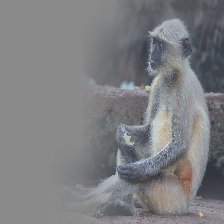

In [8]:
# Now lets see how to evaluate this explanation:
from cam_mult_image import CamMultImageConfidenceChange
from model_targets import ClassifierOutputSoftmaxTarget

# For the metrics we want to measure the change in the confidence, after softmax, that's why
# we use ClassifierOutputSoftmaxTarget.
targets = [ClassifierOutputSoftmaxTarget(368)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

The confidence increase here is positive.

That's a good sign - the CAM reduced noise from other parts of the image and retains the information that triggers the category output.

1. The "drop in confidence" metric here from the gradcam++ paper would be 0 (since it's negative).

2. The "increase in confidence" metric would be 1 (since there is an increase in confidence).

For completeness, lets see how we can use those metrics directly:

In [9]:
from cam_mult_image import DropInConfidence, IncreaseInConfidence
print("Drop in confidence", DropInConfidence()(input_tensor, grayscale_cams, targets, model))
print("Increase in confidence", IncreaseInConfidence()(input_tensor, grayscale_cams, targets, model))

Drop in confidence [0.]
Increase in confidence [1.]


Similarly, we could pertubate the image by deleting pixels with high values in the CAM. In this case, we would WANT a larger drop in the confidence.

The confidence increase percent: -0.0025268627796322107
The visualization of the pertubated image for the metric:


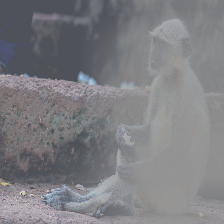

In [10]:
inverse_cams = 1 - grayscale_cams
scores, visualizations = CamMultImageConfidenceChange()(input_tensor, inverse_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

### We deleted important parts, how come it became more confident ?]
When we pertubate the supposedly impotant parts, the model actually becomes more confident than before. Maybe the CAM explanation wasn't telling us the whole story in the first place, and there are other parts that were important as well that is was missing. This shows us the importance of using complementory metrics, and how these metrics can contradict each other.

Another problem here however is that the CAM itself has values that are medium range all over it: after the pertubation, we can still see the bear in the image. Getting the Image*CAM to work requires the CAM to have a distribution that's more stretched.

This is the motivation for other methods that threshold the CAM and create binary masks. Lets completely remove the highest scoring 25%, and see that the model confidence drops now.

The confidence increase: -0.002854996593669057
The visualization of the pertubated image for the metric:


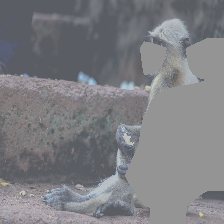

In [11]:
thresholded_cam = grayscale_cams < np.percentile(grayscale_cams, 75)
scores, visualizations = CamMultImageConfidenceChange()(input_tensor, thresholded_cam, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase: {score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

But the image above doesn't look quite natural, does it ?

### Remove and Retrain (ROAR)
https://proceedings.neurips.cc/paper/2019/hash/fe4b8556000d0f0cae99daa5c5c5a410-Abstract.html

When you pertubate the image by modifying the highest scoring regions, and the confidence decreases:

*   Is it because the explanation is good and all of cues the model was using were now removed ?
*   Or is it because of the pertubation method itself that's causing a distribution shift in the data: maybe the new image is so different than what the model expects, so un-natural, that the confidence drops.

Maybe it thinks that all that gray above is a road, or an airplane.

The claim in this paper is that the high confidence drops the different methods show, is actually because of the latter. When they pertubate the images by removing highest scoring pixels and then retrain, they the model is still actually much more accurate than expected. Because of this, they argue that we should retrain on the pertubated images to be able to adapt to the pertubations. If the explanation method still scores high - we know we can trust it much more.

They also show that common methods (altough they focused more on gradient based method and not on CAM methods) are worse on this benchmark then classical computer vision edge detector (Sobel) that doesn't depend on the model parameters at all. So basically some methods that claim they are better than others, aren't really.

Benchmarking against random explanations, or explanations that don't depend on the model (like edge detection), is a very interesting idea in itself, so lets take a look at that.

The confidence increase: -0.0028187010902911425
The visualization of the pertubated image for the metric:


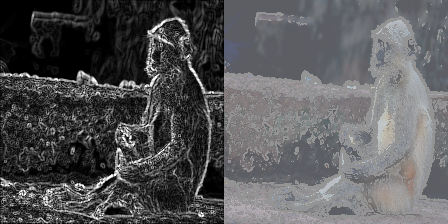

In [12]:
from sobel_cam import sobel_cam

sobel_cam_grayscale = sobel_cam(np.uint8(img * 255))
thresholded_cam = sobel_cam_grayscale < np.percentile(sobel_cam_grayscale, 75)

cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, [thresholded_cam], targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase: {score}")
print("The visualization of the pertubated image for the metric:")
sobel_cam_rgb = cv2.merge([sobel_cam_grayscale, sobel_cam_grayscale, sobel_cam_grayscale])
Image.fromarray(np.hstack((sobel_cam_rgb, visualization)))

Ok, good. So our CAM scores higher than a classic edge detector on this benchmark. That's good news !

Back to the ROAR method - Re-training a model on the pertubated images is very expensive. We don't even always know in advance what explanation method we want to chose. For many users this won't be a practical approach. Altough if the stakes are high and you want to be 100% sure about the explanation, this is something to consider.

So what can we do?

### Sanity Checks for Saliency Metrics
https://ojs.aaai.org/index.php/AAAI/article/view/6064

This paper introduces a metric called "Area Over the Perturbation Curve" - AOPC, which is the average confidence drop over different removal percentiles. (We will later call that MostRelevantFirstAverage or LeastRelevantFirstAverage since I think it's a bit more explicit and clear, but it's the same).

They check different imputation strategies:

Replacing pixels that need to be deleted, by random values.
Replacing pixels that need to be deleted, by the mean (for R,G,B separately) in the image.
Removing the highest attention pixels first: Most Relevant First (MORF).
Removing the least attention pixels first: Least Relevant First (LERF).
And then check how different algorithms differ on average acrross a dataset, but also for different individual images. Ultimately we care about an individual image - we want to make sure the explanation we use for it is reliable.

The conclusion (in my own words) is that it's a wild west. Different imputation strategies give different results. MORF and LERF give different results for different algorithms, and basically measure different properties. For the same image, it's difficult to know in advance what explanation strategy will work best.

This means that going forward, we will need a combination of metrics, will need take in mind the imputation strategy, and will definately need to look at every image individually.

### ROAD: Remove and Debias
https://proceedings.mlr.press/v162/rong22a.html

The claim in this paper is that the perbutbated image (they use the term "imputed image") itself is leaking data. Even the previous ROAR method can suffer from that. They use a beutiful example so I'm going to just paste that here:

Imagine a two-class problem that consists of detecting whether an object is located on the left or the right side of an image. A reasonable attribution method masks out pixels on the left or the right depending on the location of the object. In this case, the retraining step can lead to a classifier that infers the class just from the location of the masked out pixels and obtain high accuracy.

They further show that it's easy to train models that predict what pixels are a result of the pertubation, and that it's possible to train models with surprising accuracy using just the binary masks. So it's possible to detect the mask, and then infer things from it.

To solve this they propose a pertubation method that's more difficult to detect. And since it's good and there is less of a distribution shift, training with ROAR doesn't have an advantage any more: different metrics are more consistent with each other.

What they do is replace every pixel that needs to be removed with a weighted average of it's neighbours. Since some of it's neighbours might also need to be removed, we get system of linear equations that we have to solve, to find the new values of the pixels we want to replace.

The confidence increase when removing 25% of the image: -0.002842938294634223
The confidence increase when removing 10% of the image: -0.0017863170942291617
The visualizations:


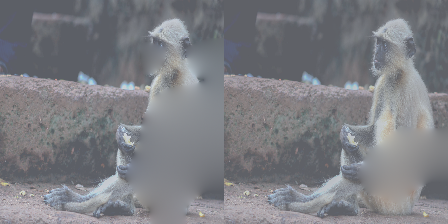

In [13]:
from road import ROADMostRelevantFirst
cam_metric = ROADMostRelevantFirst(percentile=75)
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase when removing 25% of the image: {score}")

cam_metric = ROADMostRelevantFirst(percentile=90)
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization_10 = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization_10 = deprocess_image(visualization_10)
print(f"The confidence increase when removing 10% of the image: {score}")
print("The visualizations:")
Image.fromarray(np.hstack((visualization, visualization_10)))

This is much better than replacing with the gray. But to be honest it's still quite distinguishable from the rest of the image since it's so blurry. So more work is needed to make this a convincing pertubation. GANs can be useful here (and were used in the literature for this), but are computationally expensive.

How much from the image should we remove ?

That depends on the object size and varies, so it makes sense to try different percentiles and then take the average, if we want a more robust metric.

In [4]:
from road import ROADMostRelevantFirstAverage
cam_metric = ROADMostRelevantFirstAverage(percentiles=[20, 40, 60, 80])
scores = cam_metric(input_tensor, grayscale_cams, targets, model)
print(f"The average confidence increase with ROAD accross 4 thresholds: {scores[0]}")
scores = cam_metric(input_tensor, [sobel_cam_grayscale], targets, model)
print(f"The average confidence increase for Sobel edge detection with ROAD accross 4 thresholds: {scores[0]}")

NameError: ignored

So we have ethods that can rank our model explanations. We saw we can compare that against a sobel edge detector as a sanity check to see we're better.

Lets see how to use this to get better explanations.

We will also use a toy RandomCAM that generates CAMs with random uniform values in the range [-1, 1] for the spatial activations. If our CAM methods are that smart, they should be much better than it, on average.

100%|██████████| 64/64 [00:04<00:00, 13.36it/s]


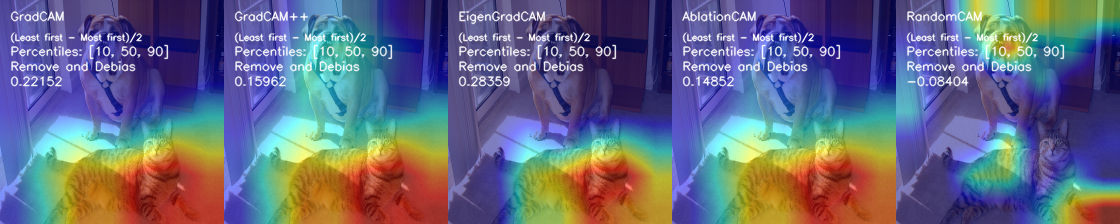

In [15]:
from grad_cam import GradCAMPlusPlus
from eigen_cam import EigenGradCAM
from ablation_cam import AblationCAM
from random_cam import RandomCAM
from road import ROADCombined

# Showing the metrics on top of the CAM : 
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    return visualization
    
def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers, use_cuda=True)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers, use_cuda=True)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers, use_cuda=True)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers, use_cuda=True))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    
    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor, 
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]    
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        visualization = show_cam_on_image(cat_and_dog, attribution, use_rgb=True)
        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
cat_and_dog = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))

#cat_and_dog_image = '/content/drive/MyDrive/Notebook/data/cat_and_dog.jpg'
#cat_and_dog = np.array(Image.open(cat_and_dog_image))

cat_and_dog = np.float32(cat_and_dog) / 255
input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

model.cuda()
input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

So EigenGradCAM is a clear winner, not unsurprisingly since it also looks smoother.

What about if we use an earlier layer with lower level features?

100%|██████████| 64/64 [00:07<00:00,  8.16it/s]


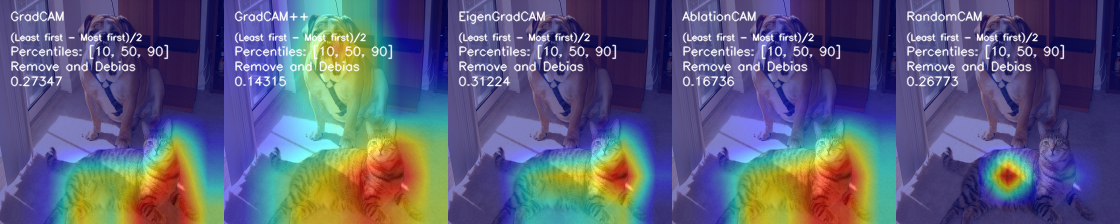

In [16]:
target_layers = [model.layer4[-2]]
benchmark(input_tensor, target_layers)

100%|██████████| 64/64 [00:08<00:00,  7.55it/s]


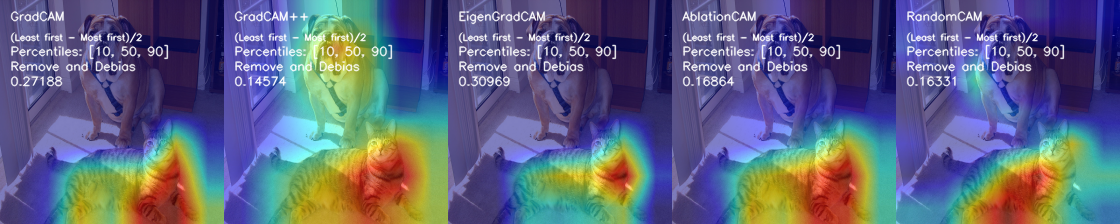

In [17]:
np.random.seed(0)
benchmark(input_tensor, target_layers)

In [ ]:
# Let's look how it looks for one of the dog categories (that the model is much less confident about)
np.random.seed(0)
benchmark(input_tensor, target_layers, category=246)

 66%|██████▌   | 42/64 [00:07<00:04,  4.67it/s]

So using this metric we can see that:

1. The different methods perform quite different.
2. You can use the metric to tune parameters like which layer or explainability method to use.
3. The explanations are quite different between the different methods.
4. A Random CAM isn't always that behind some of the methods, but still they are much better than random.

In any case we need to be suspicious about the results and double check them against benchmarks like RandomCAM or Sobel, before extracting too many insights from them.